In [217]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [218]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_nn.csv', converters={'ags2': str, 'ags5': str} )

In [219]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [220]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])


In [221]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [222]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [223]:
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2018-01-31,9.3,8.666405,6.812849,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2018-02-28,9.2,8.807995,4.260924,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2018-03-31,9.1,8.730574,4.059626,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2018-04-30,8.8,8.242456,6.335733,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2018-05-31,8.3,8.107006,2.325229,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
9619,16077,2019-08-31,7.0,7.114399,1.634277,16,Thüringen,Altenburger Land
9620,16077,2019-09-30,6.5,7.089566,9.070243,16,Thüringen,Altenburger Land
9621,16077,2019-10-31,6.5,6.721840,3.412923,16,Thüringen,Altenburger Land
9622,16077,2019-11-30,6.3,6.756373,7.244016,16,Thüringen,Altenburger Land


In [224]:
#df.to_csv('./MAPE_errors_2018_2019.csv', index = False)

## Plot each variable

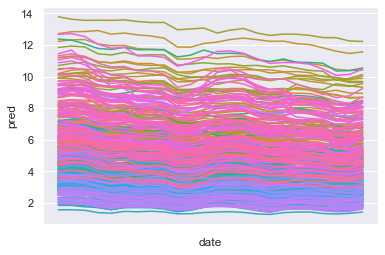

In [225]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

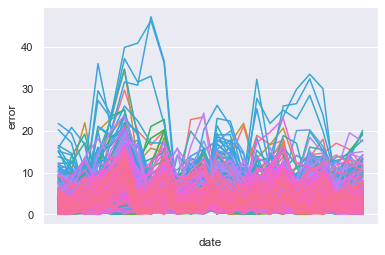

In [226]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

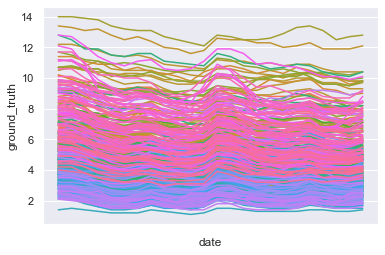

In [227]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

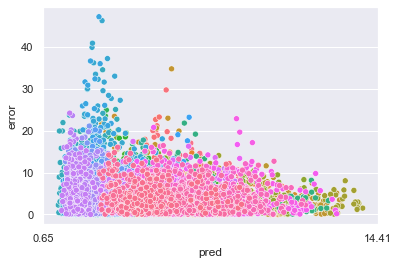

In [228]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [229]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [230]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [231]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

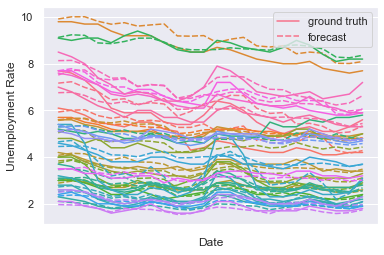

In [232]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set(xlabel='Date', ylabel='Unemployment Rate')
plt.legend(loc='upper right', labels=['ground truth', 'forecast'])
plt.savefig('sample_ur_nn_normal2.png')

## Look into mean errors

In [233]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,7.654453,6.268999
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,8.146062,3.728127
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.730177,3.150559
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.292714,2.756898
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,6.134025,6.852602
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.428801,2.981650
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.451131,3.519167
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.771823,3.731217


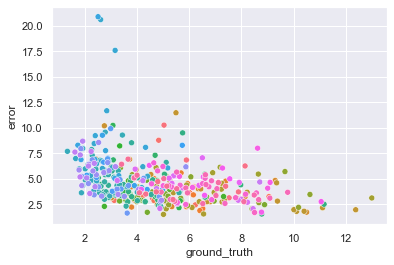

In [234]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

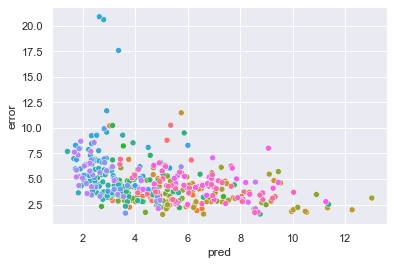

In [235]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [236]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09372,09,Freistaat Bayern,Cham,2.500000,2.619751,20.881611
09272,09,Freistaat Bayern,Freyung-Grafenau,2.600000,2.788351,20.600238
09276,09,Freistaat Bayern,Regen,3.154167,3.355386,17.584361
09275,09,Freistaat Bayern,Passau,2.833333,2.901427,11.672817
03462,03,Niedersachsen,Wittmund,5.487500,5.750702,11.477574
...,...,...,...,...,...,...
15003,15,Sachsen-Anhalt,Magdeburg,8.500000,8.558754,1.711585
09562,09,Freistaat Bayern,Erlangen,3.616667,3.619546,1.655940
05358,05,Nordrhein-Westfalen,Düren,6.545833,6.601420,1.568921


<AxesSubplot:xlabel='error', ylabel='Density'>

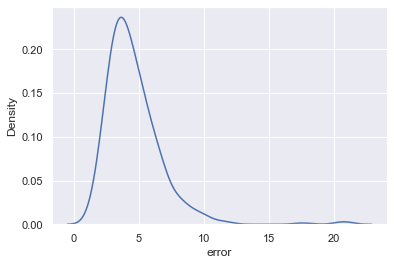

In [237]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [238]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
6271,09372,2018-08-31,2.0,2.943813,47.190665,09,Freistaat Bayern,Cham
5983,09272,2018-08-31,2.1,3.071598,46.266586,09,Freistaat Bayern,Freyung-Grafenau
5982,09272,2018-07-31,1.9,2.676769,40.882568,09,Freistaat Bayern,Freyung-Grafenau
5981,09272,2018-06-30,1.9,2.657829,39.885716,09,Freistaat Bayern,Freyung-Grafenau
6077,09276,2018-06-30,2.4,3.292904,37.204338,09,Freistaat Bayern,Regen
...,...,...,...,...,...,...,...,...
5056,08335,2019-05-31,2.9,2.899908,0.003186,08,Baden-Württemberg,Konstanz
4420,08121,2018-05-31,4.9,4.900155,0.003155,08,Baden-Württemberg,Heilbronn
5730,09184,2019-07-31,2.2,2.200044,0.002009,09,Freistaat Bayern,München
3566,07137,2019-03-31,3.4,3.400010,0.000303,07,Rheinland-Pfalz,Mayen-Koblenz


In [239]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

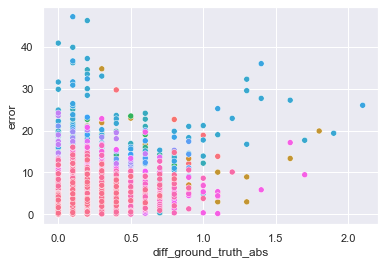

In [240]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

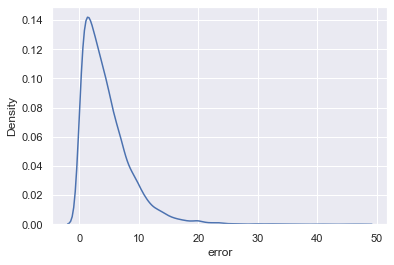

In [241]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

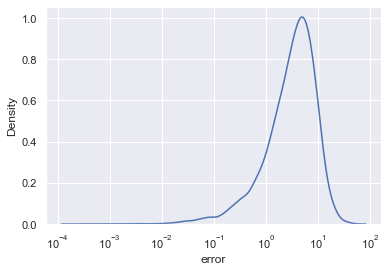

In [242]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [243]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


In [244]:
df_structural[df_structural['kreis'] == 'Stuttgart']

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
178,2,Stuttgart,08111,08,96,403,68,302,1442,265,...,1,1,1,urban,9,5,west,0,N,not_eligible_area


### Merge to df with mean errors

In [245]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [246]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    p = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    p.set_title('MAPE')
    plt.savefig(f'{column_name}_MAPE.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

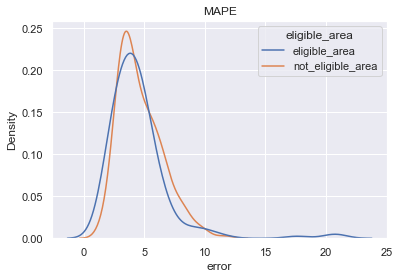

Ttest_indResult(statistic=-0.6734079795093507, pvalue=0.5012436840690466)

In [247]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

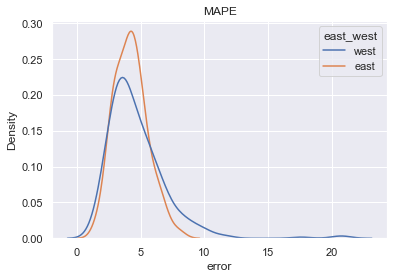

Ttest_indResult(statistic=2.436782846088571, pvalue=0.01562528422839448)

In [248]:
compare_error_in_two_groups(df_mixed, 'east_west')

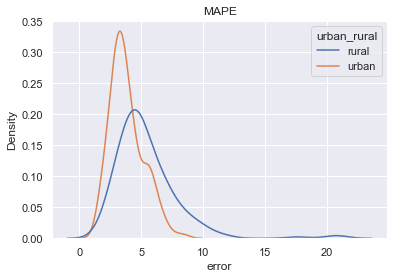

Ttest_indResult(statistic=-7.6782825837888025, pvalue=2.239286496806023e-13)

In [249]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [250]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

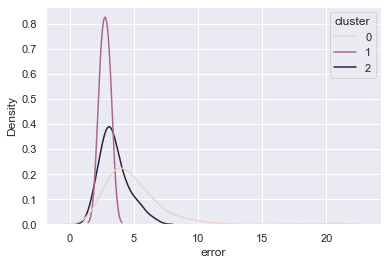

               sum_sq     df          F    PR(>F)
cluster    114.485405    1.0  24.318881  0.000001
Residual  1878.362577  399.0        NaN       NaN


In [251]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


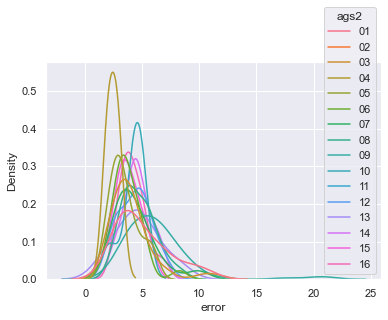

               sum_sq     df        F        PR(>F)
ags2       394.278763   15.0  6.33055  4.882484e-12
Residual  1598.569219  385.0      NaN           NaN


In [252]:
compare_error_in_two_groups(df_mixed, "ags2")

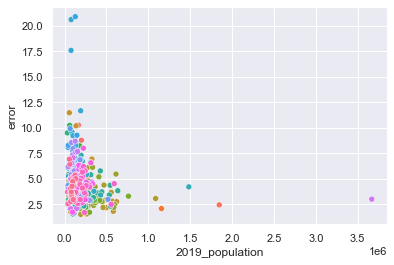

In [253]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

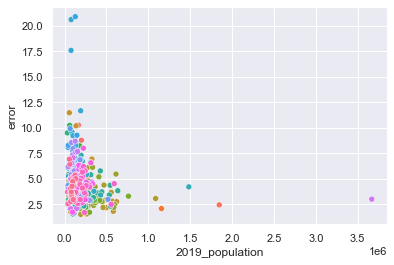

In [254]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [255]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [256]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [257]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [258]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median    3Q    Max
-0.7681 -0.1497    -0.0 0.142 0.9634


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -110.977378  4.676007e+03+1.112009e+05j  -0.0000+0.0010j  0.999205
supermarkets_population                            -0.001963  4.138600e-02-5.758000e-03j  -0.0465-0.0065j  0.962544
supermarkets_average_distance                       0.000001  2.466400e-02+2.107000e-03j   0.0001-0.0000j  0.999959
public_transport_availability                       0.002736 -3.470000e-04+8.255000e-03j  -0.0139-0.3308j  0.740730
average_distance_bus_stop                           0.000270  1.320000e-04+3.600000e-05j   1.8961-0.5129j  0.050189
average_distance_train_station                      0.000035  8.500000e-05+4.500000e-05j   0.3197-0.1685j  0.717990
average_distance_public_transport                  -0.000517  4.500000e-04+3.250000e-04

### Sequential Feature Selector

In [259]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [260]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(177,)","[-0.05407923092122813, -0.04367590766793916, -...",-0.030265,"(ags2_09,)",0.022535,0.017533,0.008766
2,"(0, 177)","[0.1557506125660142, -0.01767933155798085, -0....",0.108056,"(supermarkets_population, ags2_09)",0.135147,0.105149,0.052575
3,"(0, 77, 177)","[0.23152222431538227, -0.012450007520524498, -...",0.147881,"(supermarkets_population, number_accomodation_...",0.164781,0.128205,0.064102
4,"(0, 77, 116, 177)","[0.33166320215814893, 0.02917291465540517, 0.0...",0.179026,"(supermarkets_population, number_accomodation_...",0.147532,0.114785,0.057392
5,"(0, 77, 111, 116, 177)","[0.3461535626900778, -0.007564470018894598, 0....",0.194898,"(supermarkets_population, number_accomodation_...",0.162781,0.126649,0.063325
6,"(0, 74, 77, 111, 116, 177)","[0.3517963519842844, 0.020686166890979574, 0.1...",0.209236,"(supermarkets_population, Commute_within_50km,...",0.14605,0.113632,0.056816
7,"(0, 32, 74, 77, 111, 116, 177)","[0.3580362671159464, 0.022266389573089018, 0.1...",0.218791,"(supermarkets_population, public_transport_per...",0.14621,0.113756,0.056878
8,"(0, 32, 74, 77, 111, 116, 177, 193)","[0.37490253971862963, 0.02864160161804119, 0.1...",0.223839,"(supermarkets_population, public_transport_per...",0.147685,0.114904,0.057452
9,"(0, 32, 34, 74, 77, 111, 116, 177, 193)","[0.3787108499139178, 0.024815373277105257, 0.1...",0.226527,"(supermarkets_population, public_transport_per...",0.149707,0.116477,0.058238
10,"(0, 12, 32, 34, 74, 77, 111, 116, 177, 193)","[0.3932765096358105, 0.0573059124032822, 0.221...",0.232017,"(supermarkets_population, households_of_2_pers...",0.137658,0.107102,0.053551


In [261]:
list(summary_table_select['feature_names'])[:5]

[('ags2_09',),
 ('supermarkets_population', 'ags2_09'),
 ('supermarkets_population', 'number_accomodation_establishments', 'ags2_09'),
 ('supermarkets_population',
  'number_accomodation_establishments',
  'no_of_free_time',
  'ags2_09'),
 ('supermarkets_population',
  'number_accomodation_establishments',
  'no_of_shopping_malls',
  'no_of_free_time',
  'ags2_09')]

### Ridge

In [270]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [271]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.6842 -0.1483  0.0065 0.1448 1.0157


Coefficients:
                                                  Estimate                  Std. Error          t value   p value
_intercept                                       -7.200989  4.761773e+03+1.132405e+05j  -0.0000+0.0001j  0.999949
supermarkets_population                          -0.003679  2.384600e-02+5.301000e-03j  -0.1470+0.0327j  0.880369
supermarkets_average_distance                    -0.000018  6.751000e-03-7.812000e-03j  -0.0011-0.0013j  0.998623
public_transport_availability                    -0.000382  1.241700e-02+1.007100e-02j  -0.0186+0.0150j  0.980957
average_distance_bus_stop                         0.000306  1.020000e-04+1.200000e-05j   2.9513-0.3604j  0.003125
average_distance_train_station                    0.000027  4.400000e-05+5.000000e-06j   0.6103-0.0637j  0.539833
average_distance_public_transport                -0.000573  2.230000e-04+3.300000e-05j  -2.5111+0.3

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

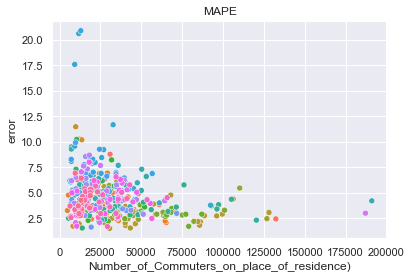

In [272]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('MAPE')
g.legend_.remove()
plt.savefig('Commuters_MAPE.png')

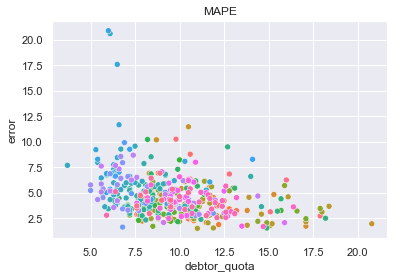

In [273]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('MAPE')
g.legend_.remove()
plt.savefig('debtor_quota_MAPE.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

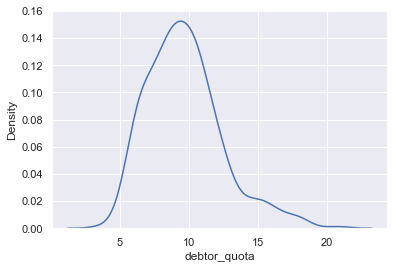

In [274]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

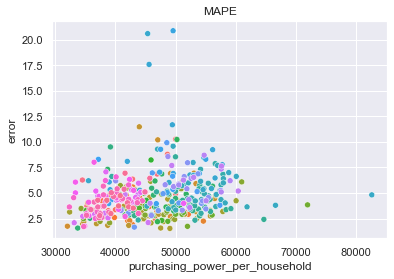

In [275]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('MAPE')
g.legend_.remove()
plt.savefig('purchasing_power_MAPE.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

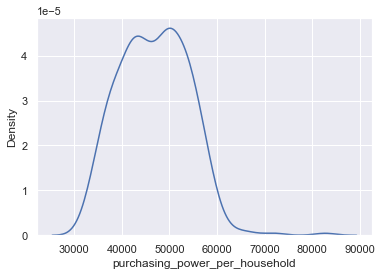

In [276]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

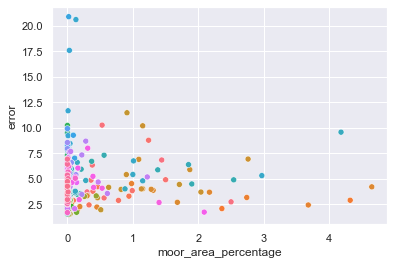

In [277]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()